# Augmentation Probability Comparison

This notebook illustrates the defense comparison with different augmentation probabilities, as presented at the Figure 5 in our paper: https://arxiv.org/abs/2411.08460.

## Prerequisites

1. Conducted the Model Training and the Model Inversion metrics to produce reconstructed samples, as instructed in [README.md](https://github.com/ntuaislab/Trap-MID/blob/main/README.md).
2. Collected and Processed the resulting data with [metric_processing.ipynb](https://github.com/ntuaislab/Trap-MID/blob/main/visualization/defense_comparison/metric_processing.ipynb).

In [3]:
%matplotlib inline

import json
import numpy as np
from matplotlib import pyplot as plt

plt.style.use('ggplot')

In [ ]:
def load_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

paths = {
    'Unprotected': '<PATH_TO_RESULT_FILE>',
    'Trap-MID (none)': '<PATH_TO_RESULT_FILE>',
    'Trap-MID (crop, p=0.5)': '<PATH_TO_RESULT_FILE>',
    'Trap-MID (crop, p=0.75)': '<PATH_TO_RESULT_FILE>',
    'Trap-MID (crop, p=0.875)': '<PATH_TO_RESULT_FILE>',
}
stats = {
    k: load_json(v)
    for k, v in paths.items()
}

In [5]:
def remove_outliers(data):
    q1, q3 = np.quantile(data, 0.25), np.quantile(data, 0.75)
    iqr = q3 - q1
    lower, upper =  q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return [d for d in data if lower <= d <= upper]

In [6]:
attack = 'PLG-MI'
attack_stats = {
    k: {
        'acc': [vv['acc'] * 100 for vv in v['Model']],
        'attack_acc': [vv['acc'] * 100 for vv in v[attack]],
        'attack_acc5': [vv['acc5'] * 100 for vv in v[attack]],
        'attack_knn_dist': [vv['knn_dist'] for vv in v[attack]],
        'attack_fid': [vv['fid'] for vv in v[attack]],
    }
    for k, v in stats.items()
}

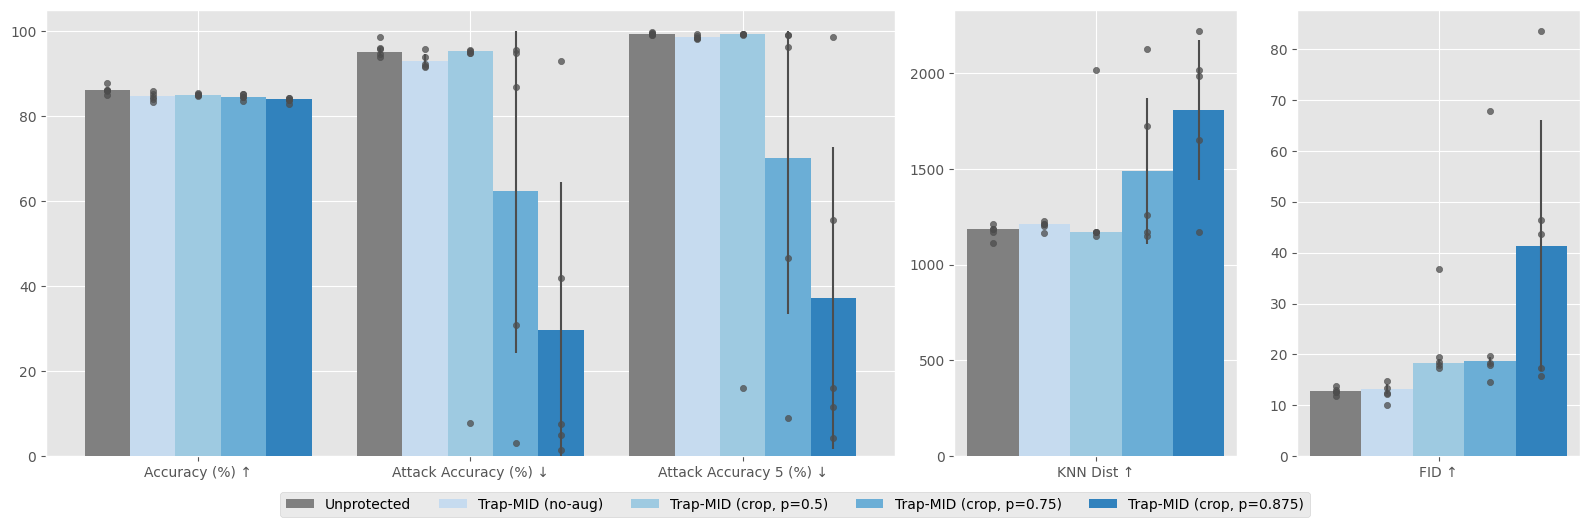

In [7]:
unprotected = ['Unprotected']
defenses = ['Trap-MID (none)', 'Trap-MID (crop, p=0.5)', 'Trap-MID (crop, p=0.75)', 'Trap-MID (crop, p=0.875)']

metrics = ['acc', 'attack_acc', 'attack_acc5']
x = np.arange(len(metrics))
n = len(unprotected + defenses)
offset = 0
width = 1 / (n+1)
cmap = plt.get_cmap('tab20c')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'width_ratios': [3, 1, 1]})

grayscales = np.linspace(0.5, 0.7, len(unprotected))
plots = []
for label, grayscale in zip(unprotected, grayscales):
    y = list(map(lambda x: np.mean(remove_outliers(attack_stats[label][x])), metrics))
    yerr = list(map(lambda x: np.std(remove_outliers(attack_stats[label][x])), metrics))
    plots.append(ax1.bar(x + offset, y, width, label=label, zorder=10, color=str(grayscale)))
    ax1.errorbar(x + offset, y, (np.minimum(y, yerr), np.minimum(100-np.array(y), yerr)), fmt="none", color='0.3', zorder=100)
    for xx, yy in zip(x + offset, list(map(lambda x: attack_stats[label][x], metrics))):
        ax1.scatter([xx] * len(yy), yy, s=20, color='0.3', zorder=1000, alpha=0.75)
    offset += width

for i, label in enumerate(defenses):
    y = list(map(lambda x: np.mean(remove_outliers(attack_stats[label][x])), metrics))
    yerr = list(map(lambda x: np.std(remove_outliers(attack_stats[label][x])), metrics))
    plots.append(ax1.bar(x + offset, y, width, label=label, zorder=10,
            color=cmap.colors[len(defenses)-1-i]
    ))
    ax1.errorbar(x + offset, y, (np.minimum(y, yerr), np.minimum(100-np.array(y), yerr)), fmt="none", color='0.3', zorder=100)
    for xx, yy in zip(x + offset, list(map(lambda x: attack_stats[label][x], metrics))):
        ax1.scatter([xx] * len(yy), yy, s=20, color='0.3', zorder=1000, alpha=0.75)
    offset += width

ax1.set_xticks(x + width * (n - 1) / 2, ['Accuracy (%) ↑', 'Attack Accuracy (%) ↓', 'Attack Accuracy 5 (%) ↓'])
ax1.grid(zorder=1)

metrics = ['attack_knn_dist']
x = np.arange(len(metrics))
offset = 0
for label, grayscale in zip(unprotected, grayscales):
    y = list(map(lambda x: np.mean(remove_outliers(attack_stats[label][x])), metrics))
    yerr = list(map(lambda x: np.std(remove_outliers(attack_stats[label][x])), metrics))
    ax2.bar(x + offset, y, width, label=label, zorder=10, color=str(grayscale))
    ax2.errorbar(x + offset, y, (np.minimum(y, yerr), yerr), fmt="none", color='0.3', zorder=100)
    for xx, yy in zip(x + offset, list(map(lambda x: attack_stats[label][x], metrics))):
        ax2.scatter([xx] * len(yy), yy, s=20, color='0.3', zorder=1000, alpha=0.75)
    offset += width

for i, label in enumerate(defenses):
    y = list(map(lambda x: np.mean(remove_outliers(attack_stats[label][x])), metrics))
    yerr = list(map(lambda x: np.std(remove_outliers(attack_stats[label][x])), metrics))
    ax2.bar(x + offset, y, width, label=label, zorder=10,
            color=cmap.colors[len(defenses)-1-i]
    )
    ax2.errorbar(x + offset, y, (np.minimum(y, yerr), yerr), fmt="none", color='0.3', zorder=100)
    for xx, yy in zip(x + offset, list(map(lambda x: attack_stats[label][x], metrics))):
        ax2.scatter([xx] * len(yy), yy, s=20, color='0.3', zorder=1000, alpha=0.75)
    offset += width

ax2.set_xticks(x + width * (n - 1) / 2, ['KNN Dist ↑'])
ax2.grid(zorder=1)

metrics = ['attack_fid']
x = np.arange(len(metrics))
offset = 0
for label, grayscale in zip(unprotected, grayscales):
    y = list(map(lambda x: np.mean(remove_outliers(attack_stats[label][x])), metrics))
    yerr = list(map(lambda x: np.std(remove_outliers(attack_stats[label][x])), metrics))
    ax3.bar(x + offset, y, width, label=label, zorder=10, color=str(grayscale))
    ax3.errorbar(x + offset, y, (np.minimum(y, yerr), yerr), fmt="none", color='0.3', zorder=100)
    for xx, yy in zip(x + offset, list(map(lambda x: attack_stats[label][x], metrics))):
        ax3.scatter([xx] * len(yy), yy, s=20, color='0.3', zorder=1000, alpha=0.75)
    offset += width

for i, label in enumerate(defenses):
    y = list(map(lambda x: np.mean(remove_outliers(attack_stats[label][x])), metrics))
    yerr = list(map(lambda x: np.std(remove_outliers(attack_stats[label][x])), metrics))
    ax3.bar(x + offset, y, width, label=label, zorder=10,
            color=cmap.colors[len(defenses)-1-i]
    )
    ax3.errorbar(x + offset, y, (np.minimum(y, yerr), yerr), fmt="none", color='0.3', zorder=100)
    for xx, yy in zip(x + offset, list(map(lambda x: attack_stats[label][x], metrics))):
        ax3.scatter([xx] * len(yy), yy, s=20, color='0.3', zorder=1000, alpha=0.75)
    offset += width

ax3.set_xticks(x + width * (n - 1) / 2, ['FID ↑'])
ax3.grid(zorder=1)

fig.tight_layout()

fig.legend(
    plots,
    ['Unprotected', 'Trap-MID (no-aug)', 'Trap-MID (crop, p=0.5)', 'Trap-MID (crop, p=0.75)', 'Trap-MID (crop, p=0.875)'],
    loc='upper center', bbox_to_anchor=(0.5, 0.02), ncols=5
)

fig.show()